In [1]:
import numpy as np
import scipy.stats as stats             # For distribution functions
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import axes3d # For 3D graphs

plt.rcParams['axes.axisbelow'] = True   # Set axes and grid elements to be below the figure
# %matplotlib widget

## Brownian Bridge

$$
dX_t = \frac{b - X_t}{T - t} dt + \sigma dW_t
$$

![Brownian Bridge](brownian_bridge.png)

In [2]:
# Simulate the Brownian Bridge
N_SIMS = 10000                           # FIXME: number of simulations
N_STEPS = 200                            # FIXME: number of steps (excluding t = 0)
SIGMA = 0.07                             # FIXME: volatility
MU = 0.07                                # FIXME: long-term mean
A = 0.8                                  # FIXME: initial value
B = 1.2                                  # FIXME: final value
S = 0                                    # FIXME: starting time
T = 1                                    # FIXME: time horizon

# Deriving Time Steps
dt = T / N_STEPS
t_steps = np.linspace(0, T, N_STEPS + 1)

# Theoretical Statistics
exact_mean = A + (B - A) * (t_steps - S) / (T - S)
exact_var = SIGMA**2 * (t_steps - S) * (T - t_steps) / (T - S)

# Simulating
Z = np.random.normal(loc = 0, scale = 1, size = (N_STEPS, N_SIMS))
X = np.vstack([np.full(N_SIMS, A), 
               np.zeros((N_STEPS - 1, N_SIMS)),
               np.full(N_SIMS, B)])

# Euler-Maruyama Method
for i in range(N_STEPS - 1): # Notice we do not compute the last step
    X[i + 1] = X[i] + (B - X[i]) / (N_STEPS - i + 1) + SIGMA * np.sqrt(dt) * Z[i]

# Alternative method using ABM: X(t) = W(t) + (b-W(T))/T*t

# Compute the increments of driftless arithmetic Brownian motion
dW = SIGMA * np.random.randn(N_STEPS, N_SIMS) * np.sqrt(dt)

# Accumulate the increments of arithmetic Brownian motion
W = np.cumsum(np.vstack([A * np.ones((1, N_SIMS)), dW]), axis=0)

# Compute the Brownian bridge with X(t) = W(t) + (b-W(T))/T*t
Y = W + np.tile((B - W[-1, :]) / T, (N_STEPS + 1, 1)) * np.tile(t_steps[:, np.newaxis], (1, N_SIMS))

# STAISTICS ========================================================================================
exact_mean = A + (t_steps - S) / (T - S) * (B - A)
exact_var = SIGMA**2 * (t_steps - S) * (T - t_steps) / (T - S)

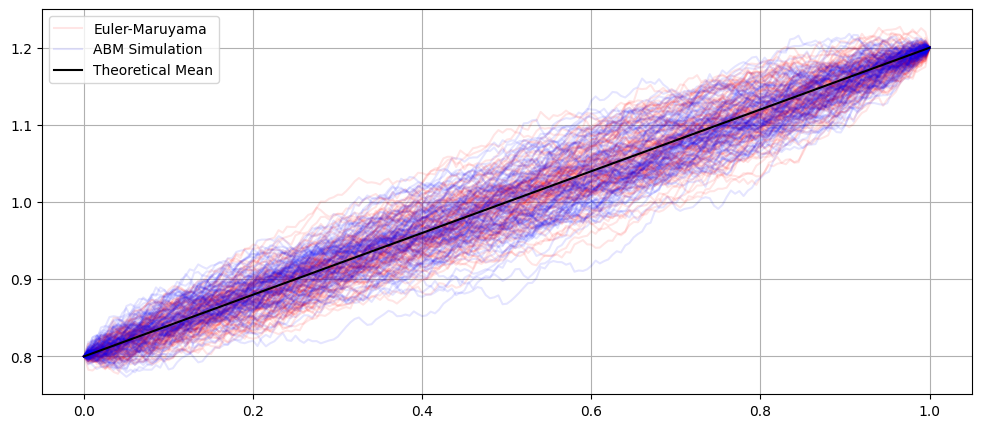

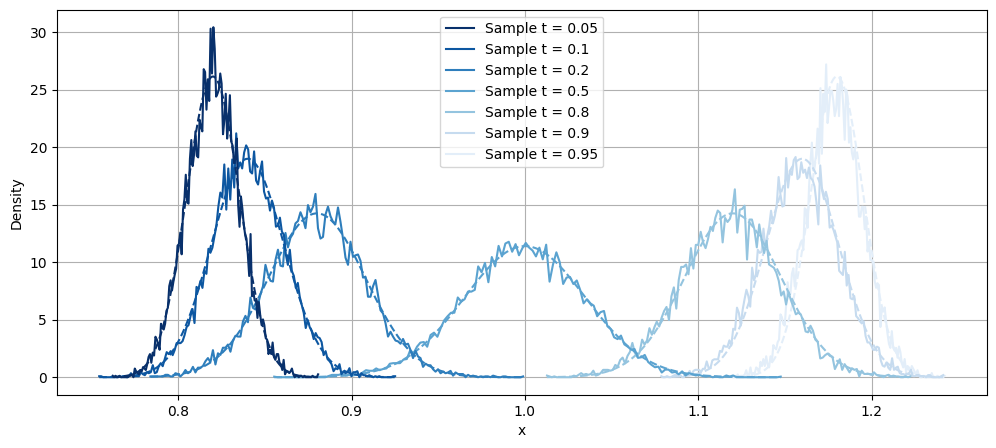

In [3]:
# Trajectories and Slices
# Plotting ====================================================================
# Trajectories ----------------------------------------------------------------
plt.figure(figsize = (12, 5), clear = True)

# Samples
plt.plot(t_steps, X[:, 0:100], color = 'red', alpha = 0.1, label = "Euler-Maruyama")
plt.plot(t_steps, Y[:, 100:200], color = 'blue', alpha = 0.1, label = "ABM Simulation")

# Theoretical and Asymptotic Mean
plt.plot(t_steps, exact_mean, color = 'black', linestyle = '-', label = 'Theoretical Mean')

# Add legend and grid
handles, labels = plt.gca().get_legend_handles_labels() # This gets the handles and labels of the current axes
by_label = dict(zip(labels, handles)) # dict(zip(keys, values)) is a way to create a dictionary from two lists
plt.legend(by_label.values(), by_label.keys())
plt.grid()

plt.show()

# Slices ---------------------------------------------------------------------
SLICES = [0.05, 0.1, 0.2, 0.5, 0.8, 0.9, 0.95]       # FIXME: times to plot

plt.figure(figsize = (12, 5), clear = True)

colors = plt.cm.Blues(np.linspace(0.1, 1, len(SLICES)))

for i, time in enumerate(SLICES[::-1]):
    p, x = np.histogram(X[int(time * N_STEPS)], bins = 150, density = True)
    x = (x[:-1] + x[1:]) / 2 # Get the middle point of each bin

    # Theoretical density
    loc = exact_mean[int(time * N_STEPS)]
    scale = np.sqrt(exact_var[int(time * N_STEPS)])

    plt.plot(x, p, color = colors[i], linestyle = "-", label = f"Sample t = {time}")
    plt.plot(x, stats.norm.pdf(x, loc = loc, scale = scale), color = colors[i], linestyle = "--")

plt.xlabel("x")
plt.ylabel("Density")

handles, labels = plt.gca().get_legend_handles_labels()
handles = handles[::-1]  # Reverse the order of handles
labels = labels[::-1]  # Reverse the order of labels
plt.legend(handles, labels)
plt.grid()
plt.show()

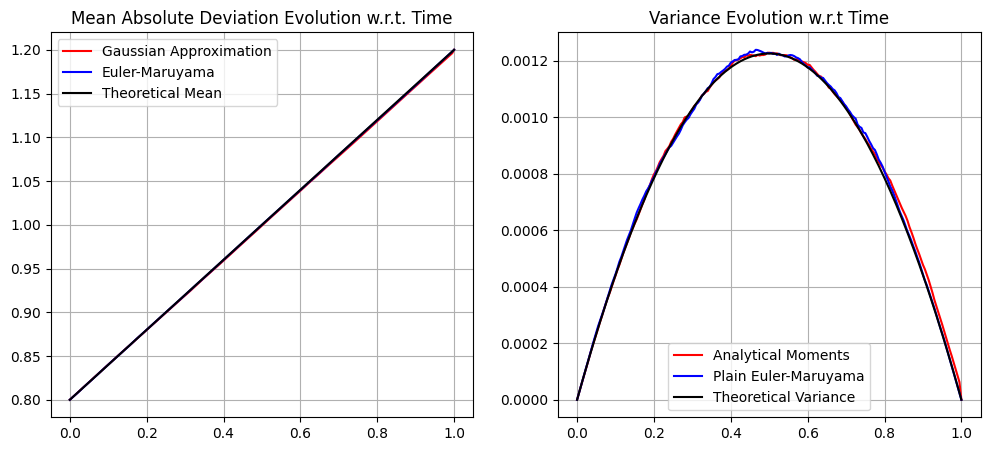

In [4]:
# CHECKING CONVERGENCE ==============================================================================
fig, ax = plt.subplots(1, 2, figsize = (12, 5), clear = True)

ax[0].set_title("Mean Absolute Deviation Evolution w.r.t. Time")

# Mean Convergence ------------------------------------------------------------------
ax[0].plot(t_steps, X.mean(axis = 1), color = "red", label = "Gaussian Approximation")
ax[0].plot(t_steps, Y.mean(axis = 1), color = "blue", label = "Euler-Maruyama")

# Theoretical and Asymptotic Mean
ax[0].plot(t_steps, exact_mean, color = "black", label = r"Theoretical Mean")

ax[0].grid()
ax[0].legend()

ax[1].set_title("Variance Evolution w.r.t Time")

# Variance Convergence --------------------------------------------------------------
ax[1].plot(t_steps, X.var(axis = 1), color = "red", label = "Analytical Moments")
ax[1].plot(t_steps, Y.var(axis = 1), color = "blue", label = "Plain Euler-Maruyama")

# Theoretical and Asymptotic Variance
ax[1].plot(t_steps, exact_var, color = "black", label = r"Theoretical Variance")

ax[1].grid()
ax[1].legend()

plt.show()

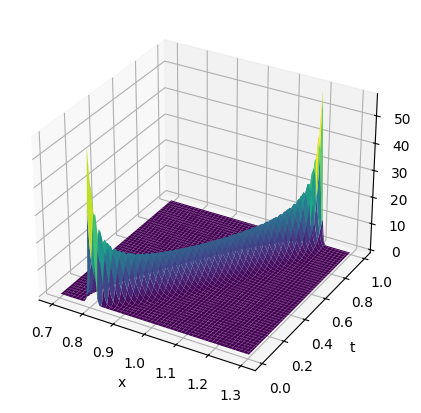

In [5]:
# %matplotlib widget
def mean_bb(t, a, b):
    return a + (b - a) * t

def var_bb(t, a, b, sigma):
    return sigma**2 * t * (1 - t)

x = np.linspace(0.7, 1.3, 100)
t = np.linspace(0.01, 0.99, 100)
XV, TV = np.meshgrid(x, t)
ZV = stats.norm.pdf(XV, loc = mean_bb(TV, A, B), scale = np.sqrt(var_bb(TV, A, B, SIGMA)))

fig = plt.figure(figsize = (12, 5), clear = True)
ax = fig.add_subplot(111, projection = '3d')
ax.set_label("Evolution of Brownian Bridge Density")
ax.plot_surface(XV, TV, ZV, cmap = 'viridis')
ax.set_xlabel('x')
ax.set_ylabel('t')
ax.set_zlabel('Density')
plt.show()